In [1]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()



status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net
Status: Status.OK
Toplogy: LBNL: { cpu: 6/6 , core: 178/192 , ram: 1,508/1,536 G, disk: 9,480/9,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 9,000/10,000 G, unit: 9/10 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 0/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
	Site Interfaces:
UKY: { cpu: 6/6 , core: 188/192 , ram: 1,528/1,536 G, disk: 9,596.9/9,600 G, unit: 3/3 }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
	Site Interf

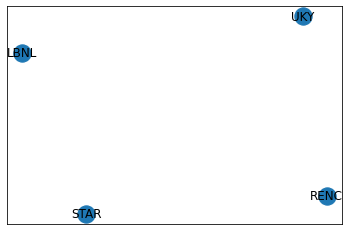

In [2]:
if status == Status.OK:
    advertised_topology.draw()

In [3]:
ssh_key_file_priv=os.environ['HOME']+"/.ssh/id_rsa"
ssh_key_file_pub=os.environ['HOME']+"/.ssh/id_rsa.pub"

ssh_key_pub = None
with open (ssh_key_file_pub, "r") as myfile:
    ssh_key_pub=myfile.read()
    ssh_key_pub=ssh_key_pub.strip()

ssh_key_priv = None
with open (ssh_key_file_priv, "r") as myfile:
    ssh_key_priv=myfile.read()
    ssh_key_priv=ssh_key_priv.strip()

In [27]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='LBNL')

# Set capacities
cap = Capacities()
cap.set_fields(core=6, ram=6, disk=10)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_7')

# Add PCI devices
n1.add_component(ctype=ComponentType.NVME, model='P4510', name='c1')

# Add node
n2 = t.add_node(name='n2', site='LBNL')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_7')

# Shared Cards
n1.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name='n1-nic1')
n2.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name='n2-nic1')

# L2Bridge Service
t.add_network_service(name='bridge1', nstype=ServiceType.L2Bridge, interfaces=t.interface_list)

# Generate Slice Graph
slice_graph = t.serialize()


# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='iperf-test12', slice_graph=slice_graph, ssh_key=ssh_key_pub)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "c77ca195-925d-4391-aaa7-21eac5594a4a",
    "lease_end": "2021-09-15 17:36:46",
    "pending_state": "None_",
    "reservation_id": "39aa41c1-3629-4458-9aa5-768fbeb2f22a",
    "reservation_state": "Unknown",
    "slice_id": "dd4ae601-909c-4c6d-b890-37460b15bd4f"
}, {
    "graph_node_id": "ce029ff6-bda0-4ca3-b547-c9a4857f1ed3",
    "lease_end": "2021-09-15 17:36:46",
    "pending_state": "None_",
    "reservation_id": "b934e08f-b6b0-4c4b-b2eb-e5486b09a4ba",
    "reservation_state": "Unknown",
    "slice_id": "dd4ae601-909c-4c6d-b890-37460b15bd4f"
}, {
    "graph_node_id": "6f1458d3-bc56-434b-b096-0f03ab6b3d02",
    "lease_end": "2021-09-15 17:36:46",
    "pending_state": "None_",
    "reservation_id": "064ee35d-d9b4-4586-9849-0b4973b4ac20",
    "reservation_state": "Unknown",
    "slice_id": "dd4ae601-909c-4c6d-b890-37460b15bd4f"
}]


In [28]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

In [29]:
status, slices = slice_manager.slices()

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "8213c06f-a96b-424b-9874-4866d94b0eaf",
    "lease_end": "2021-09-01 19:12:13",
    "slice_id": "9765dd97-1ac7-4953-94e6-c68dbec0b0a8",
    "slice_name": "iperf-test4",
    "slice_state": "Dead"
}, {
    "graph_id": "82b99592-910a-467f-8454-60c8cbec1446",
    "lease_end": "2021-09-15 17:17:31",
    "slice_id": "4a849709-d944-4704-90f5-767bde5a8436",
    "slice_name": "iperf-test10",
    "slice_state": "Configuring"
}, {
    "graph_id": "3c908078-d86e-4469-8c3b-1bfd37e31dc3",
    "lease_end": "2021-09-08 22:29:28",
    "slice_id": "f18afd8f-5a15-446b-ae2a-1eeaeb8434ec",
    "slice_name": "iperf-test7",
    "slice_state": "Closing"
}, {
    "graph_id": "608a969a-189e-473e-a4ea-e09c59851b3b",
    "lease_end": "2021-09-03 16:42:48",
    "slice_id": "8943327e-31db-4b9b-8808-430903ed1d1b",
    "slice_name": "iperf-test4",
    "slice_state": "Dead"
}, {
    "graph_id": "e90f6042-d2d0-41b7-ac3b-e77b596202a6",
    "lease_end": "2021-09-03 16:4

In [30]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 8, \"disk\": 10, \"ram\": 32}",
    "allocated_labels": "{\"instance\": \"instance-000001e4\", \"instance_parent\": \"lbnl-w3.fabric-testbed.net\"}",
    "capacities": "{\"core\": 6, \"disk\": 10, \"ram\": 6}",
    "capacity_hints": "{\"instance_type\": \"fabric.c8.m32.d10\"}",
    "graph_node_id": "ce029ff6-bda0-4ca3-b547-c9a4857f1ed3",
    "join_state": "NoJoin",
    "lease_end": "2021-09-15 17:36:46",
    "management_ip": "198.129.61.52",
    "name": "n2",
    "pending_state": "None_",
    "reservation_id": "b934e08f-b6b0-4c4b-b2eb-e5486b09a4ba",
    "reservation_state": "Active",
    "resource_type": "VM",
    "site": "LBNL",
    "slice_id": "dd4ae601-909c-4c6d-b890-37460b15bd4f"
}, {
    "allocated_capacities": "{\"core\": 8, \"disk\": 10, \"ram\": 32}",
    "allocated_labels": "{\"instance\": \"instance-000001e3\", \"instance_parent\": \"lbnl-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 6, \"

In [31]:
server_ip = slivers[0].management_ip
server_ip

'198.129.61.52'

In [33]:
client_ip = slivers[1].management_ip
client_ip

'198.129.61.57'

In [34]:
import paramiko 
#from scp import SCPClient, SCPException
key = paramiko.RSAKey.from_private_key_file(os.environ['HOME']+"/.ssh/id_rsa")
client_server = paramiko.SSHClient()
client_server.load_system_host_keys()
client_server.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
client_server.set_missing_host_key_policy(paramiko.AutoAddPolicy())

In [41]:
client_server.connect(server_ip,username='centos',pkey = key)
stdin, stdout, stderr = client_server.exec_command('sudo rpm -hUv https://downloads.globus.org/toolkit/gt6/stable/installers/repo/rpm/globus-toolkit-repo-6.0.9-1.noarch.rpm')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Retrieving https://downloads.globus.org/toolkit/gt6/stable/installers/repo/rpm/globus-toolkit-repo-6.0.9-1.noarch.rpm
Preparing...                          ########################################

	package globus-toolkit-repo-6.0.21-1.noarch (which is newer than globus-toolkit-repo-6.0.9-1.noarch) is already installed



In [37]:
stdin, stdout, stderr = client_server.exec_command('sudo yum install -y yum-plugin-priorities')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Loaded plugins: fastestmirror
Loading mirror speeds from cached hostfile
 * base: nc-centos-mirror.iwebfusion.net
 * extras: mirror.fileplanet.com
 * updates: sjc.edge.kernel.org
Resolving Dependencies
--> Running transaction check
---> Package yum-plugin-priorities.noarch 0:1.1.31-54.el7_8 will be installed
--> Finished Dependency Resolution

Dependencies Resolved

 Package                    Arch        Version                 Repository
                                                                           Size
Installing:
 yum-plugin-priorities      noarch      1.1.31-54.el7_8         base       29 k

Transaction Summary
Install  1 Package

Total download size: 29 k
Installed size: 28 k
Public key for yum-plugin-priorities-1.1.31-54.el7_8.noarch.rpm is not installed
Retrieving key from file:///etc/pki/rpm-gpg/RPM-GPG-KEY-CentOS-7
Running transaction check
Running transaction test
Transaction test succeeded
Running transaction
  Installing : yum-plugin-priorities-1.1.31-54.el7_8

In [46]:
stdin, stdout, stderr = client_server.exec_command('sudo yum install -y  wget')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Loaded plugins: fastestmirror, priorities
Loading mirror speeds from cached hostfile
 * base: nc-centos-mirror.iwebfusion.net
 * extras: mirror.fileplanet.com
 * updates: sjc.edge.kernel.org
Resolving Dependencies
--> Running transaction check
---> Package wget.x86_64 0:1.14-18.el7_6.1 will be installed
--> Finished Dependency Resolution

Dependencies Resolved

 Package        Arch             Version                   Repository      Size
Installing:
 wget           x86_64           1.14-18.el7_6.1           base           547 k

Transaction Summary
Install  1 Package

Total download size: 547 k
Installed size: 2.0 M
Running transaction check
Running transaction test
Transaction test succeeded
Running transaction
  Installing : wget-1.14-18.el7_6.1.x86_64                                  1/1 
  Verifying  : wget-1.14-18.el7_6.1.x86_64                                  1/1 

Installed:
  wget.x86_64 0:1.14-18.el7_6.1                                                 

Complete!




In [47]:
stdin, stdout, stderr = client_server.exec_command('sudo wget https://download-ib01.fedoraproject.org/pub/epel/7/x86_64/Packages/u/udt-4.11-6.el7.x86_64.rpm')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))


--2021-09-14 17:56:57--  http://download-ib01.fedoraproject.org/pub/epel/7/x86_64/
Resolving download-ib01.fedoraproject.org (download-ib01.fedoraproject.org)... 152.19.134.145, 2610:28:3090:3001:dead:beef:cafe:fed6
Connecting to download-ib01.fedoraproject.org (download-ib01.fedoraproject.org)|152.19.134.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 975 [text/html]
Saving to: ‘index.html’

     0K                                                       100%  264M=0s

2021-09-14 17:56:57 (264 MB/s) - ‘index.html’ saved [975/975]




In [49]:
stdin, stdout, stderr = client_server.exec_command('sudo rpm -Uvh *rpm')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Loaded plugins: fastestmirror, priorities
Loading mirror speeds from cached hostfile
 * base: nc-centos-mirror.iwebfusion.net
 * extras: mirror.fileplanet.com
 * updates: sjc.edge.kernel.org
Metadata Cache Created




In [50]:
stdin, stdout, stderr = client_server.exec_command('sudo yum install -y udt')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Loaded plugins: fastestmirror, priorities
Loading mirror speeds from cached hostfile
 * base: nc-centos-mirror.iwebfusion.net
 * extras: mirror.fileplanet.com
 * updates: sjc.edge.kernel.org
No package udt available.

Error: Nothing to do



In [43]:
stdin, stdout, stderr = client_server.exec_command('sudo yum install -y udt globus-gridftp globus-gsi globus-data-management-server')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Loaded plugins: fastestmirror, priorities
Loading mirror speeds from cached hostfile
 * base: nc-centos-mirror.iwebfusion.net
 * extras: mirror.fileplanet.com
 * updates: sjc.edge.kernel.org
No package udt available.
Resolving Dependencies
--> Running transaction check
---> Package globus-data-management-server.x86_64 0:6.0-1.el7+gt6 will be installed
--> Processing Dependency: globus-gsi-cert-utils-progs for package: globus-data-management-server-6.0-1.el7+gt6.x86_64
--> Processing Dependency: globus-common-progs for package: globus-data-management-server-6.0-1.el7+gt6.x86_64
--> Processing Dependency: globus-authz for package: globus-data-management-server-6.0-1.el7+gt6.x86_64
--> Processing Dependency: globus-xio-pipe-driver for package: globus-data-management-server-6.0-1.el7+gt6.x86_64
--> Processing Dependency: globus-xioperf for package: globus-data-management-server-6.0-1.el7+gt6.x86_64
--> Processing Dependency: globus-usage for package: globus-data-management-server-6.0-1.el7

In [40]:
stdin, stdout, stderr = client_server.exec_command('/etc/init.d/globus-gridftp-sshftp reconfigure')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))


bash: /etc/init.d/globus-gridftp-sshftp: No such file or directory



In [16]:
status, result = slice_manager.delete(slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.FAILURE
Response received (500)
Reason: INTERNAL SERVER ERROR
HTTP response headers: HTTPHeaderDict({'Server': 'nginx/1.19.8', 'Date': 'Tue, 14 Sep 2021 17:21:11 GMT', 'Content-Type': 'text/html; charset=utf-8', 'Content-Length': '100', 'Connection': 'keep-alive', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Headers': 'DNT, User-Agent, X-Requested-With, If-Modified-Since, Cache-Control, Content-Type, Range', 'Access-Control-Allow-Methods': 'GET, POST, PUT, DELETE, OPTIONS', 'Access-Control-Allow-Origin': '*', 'Access-Control-Expose-Headers': 'Content-Length, Content-Range, X-Error', 'X-Error': 'Unable to delete Slice# 4a849709-d944-4704-90f5-767bde5a8436 that is not yet stable, try again later'})
HTTP response body: Unable to delete Slice# 4a849709-d944-4704-90f5-767bde5a8436 that is not yet stable, try again later

